## Importando dependências

In [1]:
# pip install tensorflow sklearn

In [2]:
import numpy as np
import sys
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import Loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Importando dataset e splitando em teste e treino

In [3]:
def normalize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    unique_labels = sorted(list(set(y)))
    for i in range(len(y)):
        y[i] = unique_labels.index(y[i])
    dataset.iloc[:, -1] = y
    
def apply_feature_scaling(dataset):
    X = dataset.iloc[:, 5:-1].values
    sc = StandardScaler()
    X = sc.fit_transform(X)
    dataset.iloc[:, 5:-1] = X

HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset = pd.read_csv('dataset-oi-2017-02-24.csv', names=HEADER)

apply_feature_scaling(initial_dataset)

normalize_dataset_labels(initial_dataset)

## Criando modelo do cliente

In [8]:
class Client:
    def __init__(self, client_id = 123, dataset = [1.0, 2.0]):
        self.client_id = client_id
        self.local_dataset = pd.DataFrame(dataset)
        self.local_tree = DecisionTreeClassifier(random_state=0, max_depth=35, criterion='entropy')
        self.metrics_history = list()
        self.local_forest = [self.local_tree]
        
    def apply_oversample(self, X, y):
        value_counts = self.local_dataset.iloc[:, -1].value_counts()
        smote_classes, random_classes, k = ({}, {}, sys.maxsize)
        max_count = max(value_counts.values)
        
        for key, value in value_counts.items():
            if value > 5:
                smote_classes[key] = max_count
                if k > value:
                    k = value - 1
            else:
                random_classes[key] = max_count
                    
        smote_oversample = SMOTE(sampling_strategy = smote_classes, k_neighbors = k)
        random_oversample = RandomOverSampler(sampling_strategy = random_classes)
        X, y = smote_oversample.fit_resample(X, y)
        return random_oversample.fit_resample(X, y)

        
    def preprocess(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values
        
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)
        
#         sc = StandardScaler()
#         X = sc.fit_transform(X)

#         X, y = self.apply_oversample(X, y)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
        
    def train_tree(self):
        # depth 35 é o melhor aplicando grid seach
        self.local_tree.fit(self.X_train, self.y_train)
        
    def test_tree(self):
        y_pred = self.local_tree.predict(self.X_test)
        
#         precision = Precision()
#         precision.update_state(self.y_test, y_pred)
#         prec = precision.result().numpy()
        
#         recall = Recall()
#         recall.update_state(self.y_test, y_pred)
#         rec = recall.result().numpy()
        
        self.local_tree_acc = self.local_tree.score(self.X_test, self.y_test)
        print(f"[INFO] Accuracy of client {self.client_id} tree = {self.local_tree_acc}")
        
        self.metrics_history.append((self.local_tree_acc, 0.0, 0.0))
#         cm = confusion_matrix(self.y_test, y_pred)
#         print(cm)  

## Splitando dataset para os clientes da rede

In [9]:
num_clients = 20
max_num_trees = 10
clients = [Client(client_id = i) for i in range(num_clients)]

# pega os N primeiros clientes com mais dados e que possuem dataset com > 1 classe
unique_ips = initial_dataset['srcip'].value_counts().head(num_clients + 10).keys()
client_index, i = (0,0)
while client_index < num_clients:
    local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[i]]
    num_classes = len(local_dataset['class'].value_counts())
    if num_classes > 1:
        clients[client_index].local_dataset = local_dataset
        client_index += 1
    i += 1
        

## Treinando e testando modelos DT locais

In [10]:
for client in clients:
    client.preprocess()
    client.train_tree()
    client.test_tree()

print("[INFO] All local trains are finished!")

[INFO] Accuracy of client 0 tree = 0.9357045886505566
[INFO] Accuracy of client 1 tree = 0.8439064536040052
[INFO] Accuracy of client 2 tree = 0.9997739431843871
[INFO] Accuracy of client 3 tree = 0.8646267525577871
[INFO] Accuracy of client 4 tree = 0.8665715644317642
[INFO] Accuracy of client 5 tree = 0.7884847671453497
[INFO] Accuracy of client 6 tree = 0.9312517118597644
[INFO] Accuracy of client 7 tree = 0.9991031390134529
[INFO] Accuracy of client 8 tree = 0.8194704049844237
[INFO] Accuracy of client 9 tree = 0.999656652360515
[INFO] Accuracy of client 10 tree = 0.9996395746981438
[INFO] Accuracy of client 11 tree = 0.9993734335839599
[INFO] Accuracy of client 12 tree = 0.9995279679018173
[INFO] Accuracy of client 13 tree = 1.0
[INFO] Accuracy of client 14 tree = 0.9997095556200988
[INFO] Accuracy of client 15 tree = 1.0
[INFO] Accuracy of client 16 tree = 1.0
[INFO] Accuracy of client 17 tree = 1.0
[INFO] Accuracy of client 18 tree = 0.999349593495935
[INFO] Accuracy of client 1

## Compartilhando DTs e atualizando FedForest

In [11]:
for current in range(num_clients):
    appended_trees, replaced_trees, acc_list = (0,0,[])
    for neighbour in range(num_clients):
        if current != neighbour:
            neighbour_tree = clients[neighbour].local_tree
            acc = neighbour_tree.score(clients[current].X_test, clients[current].y_test)
            
            if len(clients[current].local_forest) < max_num_trees:
                clients[current].local_forest.append(neighbour_tree)
                acc_list.append(acc)
                appended_trees += 1
            else:
                min_acc = min(acc_list)
                min_index = acc_list.index(min_acc) # seleciona a árvore de menor acurácia
                if min_acc < acc:
                    clients[current].local_forest[min_index] = neighbour_tree # substitui a árvore pela nova
                    acc_list[min_index] = acc
                    replaced_trees += 1
    print(f"Client {current} appended {appended_trees} and replaced {replaced_trees} trees to forest")
    print(f"{acc_list}\n")
                

Client 0 appended 9 and replaced 8 trees to forest
[0.8747759978278578, 0.8738528373608472, 0.8692913385826772, 0.8766766223187619, 0.8699429812652729, 0.8691284279120283, 0.8736356231333152, 0.8610915014933478, 0.8760249796361662]

Client 1 appended 9 and replaced 3 trees to forest
[0.5579178382826967, 0.4893354365269872, 0.6974144434538098, 0.5966668952746725, 0.49118716137439133, 0.6723818668129757, 0.48988409574103287, 0.6830121390851107, 0.4909814141691242]

Client 2 appended 9 and replaced 8 trees to forest
[0.9985683068344511, 0.997890136387612, 0.998794363650064, 0.9974380227563862, 0.9959309773189662, 0.9972873182126442, 0.9969105568532891, 0.9993218295531611, 0.998040840931354]

Client 3 appended 9 and replaced 4 trees to forest
[0.46068586585827964, 0.6981811292156119, 0.393236074270557, 0.5526714664645699, 0.3956991284577491, 0.6867184539598332, 0.39352027283061763, 0.6707086017430846, 0.3954149298976885]

Client 4 appended 9 and replaced 7 trees to forest
[0.71412268188302

## Testando a RF dos clientes

In [12]:
import statistics
from joblib import Parallel, delayed
from statistics import mode

def forest_predict(forest, X):
    forest_prediction = list()
    for row in X:
        tree_predictions = list()
        for tree in forest:
            tree_predictions.append(tree.predict([row])[0])
        forest_prediction.append(mode(tree_predictions))
    return forest_prediction

for client in clients:
    accuracy = Accuracy()
    forest_pred = forest_predict(client.local_forest, client.X_test)
    accuracy.update_state(client.y_test, forest_pred)
    acc = accuracy.result().numpy()
    client.local_forest_acc = acc
    
    print(f"[INFO] Accuracy of client {client.client_id} forest = {acc}")

[INFO] Accuracy of client 0 forest = 0.876676619052887
[INFO] Accuracy of client 1 forest = 0.4911871552467346
[INFO] Accuracy of client 2 forest = 0.9993218183517456
[INFO] Accuracy of client 3 forest = 0.3956991136074066
[INFO] Accuracy of client 4 forest = 0.7170708775520325
[INFO] Accuracy of client 5 forest = 0.34277278184890747
[INFO] Accuracy of client 6 forest = 0.8323746919631958
[INFO] Accuracy of client 7 forest = 0.9913303256034851
[INFO] Accuracy of client 8 forest = 0.686604380607605
[INFO] Accuracy of client 9 forest = 0.9960514903068542
[INFO] Accuracy of client 10 forest = 0.9992791414260864
[INFO] Accuracy of client 11 forest = 0.999791145324707
[INFO] Accuracy of client 12 forest = 0.9818267822265625
[INFO] Accuracy of client 13 forest = 0.9939655065536499
[INFO] Accuracy of client 14 forest = 0.9997095465660095
[INFO] Accuracy of client 15 forest = 0.9970466494560242
[INFO] Accuracy of client 16 forest = 0.9787106513977051
[INFO] Accuracy of client 17 forest = 0.997

## Plotando resultados dos treinos locais

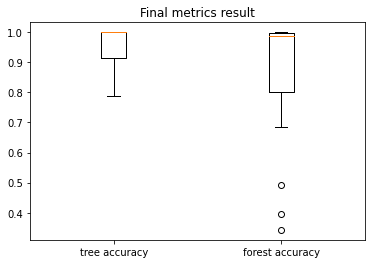

In [13]:
final_metrics = [[], []]
for client in clients:
    final_metrics[0].append(client.local_tree_acc)
    final_metrics[1].append(client.local_forest_acc)

plt.boxplot(final_metrics)
plt.title('Final metrics result')
plt.xticks([1, 2], ['tree accuracy', 'forest accuracy'])
plt.show()